In [1]:
# pip uninstall scikit-learn

In [2]:
# pip install scikit-learn==1.2.2

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC,RandomOverSampler,KMeansSMOTE


import warnings 
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data_sets/hypothyroid.csv')

In [5]:
df.shape

(3772, 30)

In [6]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,negative


### Problem Statement :  To build a classification methodology to predict the type of Thyroid a person has, based on the below features.

### Data Description:

age - Age of the person

sex - Male or Female

on_thyroxine - true or false

on_antithyroid_medication - true or false

sick - true or false

pregnant - true or false

thyroid_surgery - true or false

I131_treatment - true or false

query_hypothyroid - true or false

query_hyperthyroid -true or false

lithium - true or false

goitre - true or false

tumor - true or false

hypopituitary- true or false

psych - true or false

TSH_measured - true or false

TSH - thyroid stimulating hormone floating value

T3_measured - true or false

T3 - triiodothyronine value

TT4_measured- true or false

TT4 - Thyroxine value

T4U_measured- true or false

T4U - numerical value

FTI_measured- true or false

FTI -Free Thyroxine Index

TBG_measured- true or false

TBG -Thyroid-Binding Globulin  value

referral_source - different sources of referals

Class - different types of thyroid

In [7]:
df.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
count,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,...,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772
unique,94,3,2,2,2,2,2,2,2,2,...,2,242,2,147,2,235,1,1,5,4
top,59,F,f,f,f,f,f,f,f,f,...,t,?,t,?,t,?,f,?,other,negative
freq,95,2480,3308,3722,3729,3625,3719,3719,3713,3538,...,3541,231,3385,387,3387,385,3772,3772,2201,3481


##### Checking Nulls

We can see from the data description that there are no missing values. But we can observe the dataset has missing values that are replaced with invalid values like '?'. Let's replace such values with 'nan' and check for missing values again.

In [8]:
for column in df.columns:
    count = df[column][df[column]=='?'].count()
    if count!=0:
        print(column, df[column][df[column]=='?'].count())
    

age 1
sex 150
TSH 369
T3 769
TT4 231
T4U 387
FTI 385
TBG 3772


So these are the columns which have missing values but missing values are replaced with '?'. We will replace these values with 'nan' and then do imputation of these missing values. 

Also, we can see that for column 'TBG' all the values are missing. So we will drop this column as it is of no use to us.

In [9]:
df = df.drop(['TBG'],axis =1)

In [10]:
# Now let's replace the '?' values with numpy nan
for column in df.columns:
    count = df[column][df[column]=='?'].count()
    if count!=0:
        df[column] = df[column].replace('?',np.nan)    

In [11]:
df.isna().sum()[df.isna().sum() > 0]

age      1
sex    150
TSH    369
T3     769
TT4    231
T4U    387
FTI    385
dtype: int64

##### Unwanted columns

Also, looking to the dataset, we can see that some columns are with true and false values which is just the indication that whether the next column has values or not. Let's see an example:

In [12]:
df[['T4U_measured','T4U']].head(11)

,T4U_measured,T4U
0,t,1.14
1,f,NaN
2,t,0.91
3,f,NaN
4,t,0.87
5,t,1.3
6,t,0.92
7,t,0.7
8,t,0.93
9,t,0.89


In [13]:
df = df.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured'],axis =1)

##### Encoding Categorical values

Since the values are categorical, we have to change them to numerical before we use any imputation techniques.

We can use get dummies but since most of the columns have only two distinct categories we will use mapping for them. 
For columns with more than two categories we will use get dummies.

In [14]:
# for column in df.columns:
#     print(column, (df[column].unique()),end='\n\n')

In [15]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,...,f,f,f,1.3,2.5,125,1.14,109,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,...,f,f,f,4.1,2,102,NaN,NaN,other,negative
2,46,M,f,f,f,f,f,f,f,f,...,f,f,f,0.98,NaN,109,0.91,120,other,negative
3,70,F,t,f,f,f,f,f,f,f,...,f,f,f,0.16,1.9,175,NaN,NaN,other,negative
4,70,F,f,f,f,f,f,f,f,f,...,f,f,f,0.72,1.2,61,0.87,70,SVI,negative


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3771 non-null   object
 1   sex                        3622 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [17]:
df['Class'].value_counts()

Class
negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: count, dtype: int64

In [18]:
# We can map the categorical values like below:
df['sex'] = df['sex'].map({'F' : 0, 'M' : 1})

# except for 'sex' column all the other columns with two categorical data have same value 'f' and 't'.
# so instead of mapping indvidually, let's create a loop
for column in df.columns:
    if  len(df[column].unique())==2:
        df[column] = df[column].map({'f' : 0, 't' : 1})
        
# Now let's handle columns with more than 2 categories. 


In [19]:
df['referral_source'].unique()

array(['SVHC', 'other', 'SVI', 'STMW', 'SVHD'], dtype=object)

In [20]:
# we will use get_dummies
df = pd.get_dummies(df, columns=['referral_source'], dtype=float, drop_first=True)

In [21]:
df['Class'].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

Now our ouptut class also has 4 distinct categories. There is no sense of using get dummies with our Output class, so we will just map them.
Let's use LabelEncoder function for this.

In [22]:
lblEn = LabelEncoder()

df['Class'] =lblEn.fit_transform(df['Class'])

In [23]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3,TT4,T4U,FTI,Class,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,...,1.3,2.5,125,1.14,109,1,1.0,0.0,0.0,0.0
1,23,0.0,0,0,0,0,0,0,0,0,...,4.1,2,102,NaN,NaN,1,0.0,0.0,0.0,1.0
2,46,1.0,0,0,0,0,0,0,0,0,...,0.98,NaN,109,0.91,120,1,0.0,0.0,0.0,1.0
3,70,0.0,1,0,0,0,0,0,0,0,...,0.16,1.9,175,NaN,NaN,1,0.0,0.0,0.0,1.0
4,70,0.0,0,0,0,0,0,0,0,0,...,0.72,1.2,61,0.87,70,1,0.0,0.0,1.0,0.0


In [24]:
df.describe(include='all')

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3,TT4,T4U,FTI,Class,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3771,3622.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3403,3003,3541,3385,3387,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
unique,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,287,69,241,146,234,NaN,NaN,NaN,NaN,NaN
top,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2,2,101,0.99,100,NaN,NaN,NaN,NaN,NaN
freq,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,116,238,71,95,73,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.315295,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,NaN,NaN,NaN,NaN,NaN,0.974814,0.102333,0.010339,0.274125,0.583510
std,NaN,0.464698,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,NaN,NaN,NaN,NaN,NaN,0.279508,0.303126,0.101169,0.446131,0.493042
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,1.000000
75%,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,1.000000,1.000000


##### Imputing Missing values

In [25]:
imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
arr = imputer.fit_transform(df) # impute the missing values
    
# converting the above array in to a Dataframe
new_df = pd.DataFrame(data=np.round(arr), columns=df.columns)

In [26]:
new_df.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3,TT4,T4U,FTI,Class,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,...,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,51.737275,0.307529,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,...,4.830594,2.027837,108.542153,1.020944,110.363468,0.974814,0.102333,0.010339,0.274125,0.583510
std,20.082478,0.461532,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,...,23.323891,0.786399,35.009868,0.165546,32.275460,0.279508,0.303126,0.101169,0.446131,0.493042
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,88.000000,1.000000,93.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,104.000000,1.000000,107.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,67.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,2.000000,124.000000,1.000000,124.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,455.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,530.000000,11.000000,430.000000,2.000000,395.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
new_df.isna().sum()[new_df.isna().sum() > 0]

Series([], dtype: int64)

##### Distribution of our Continous data in the dataset

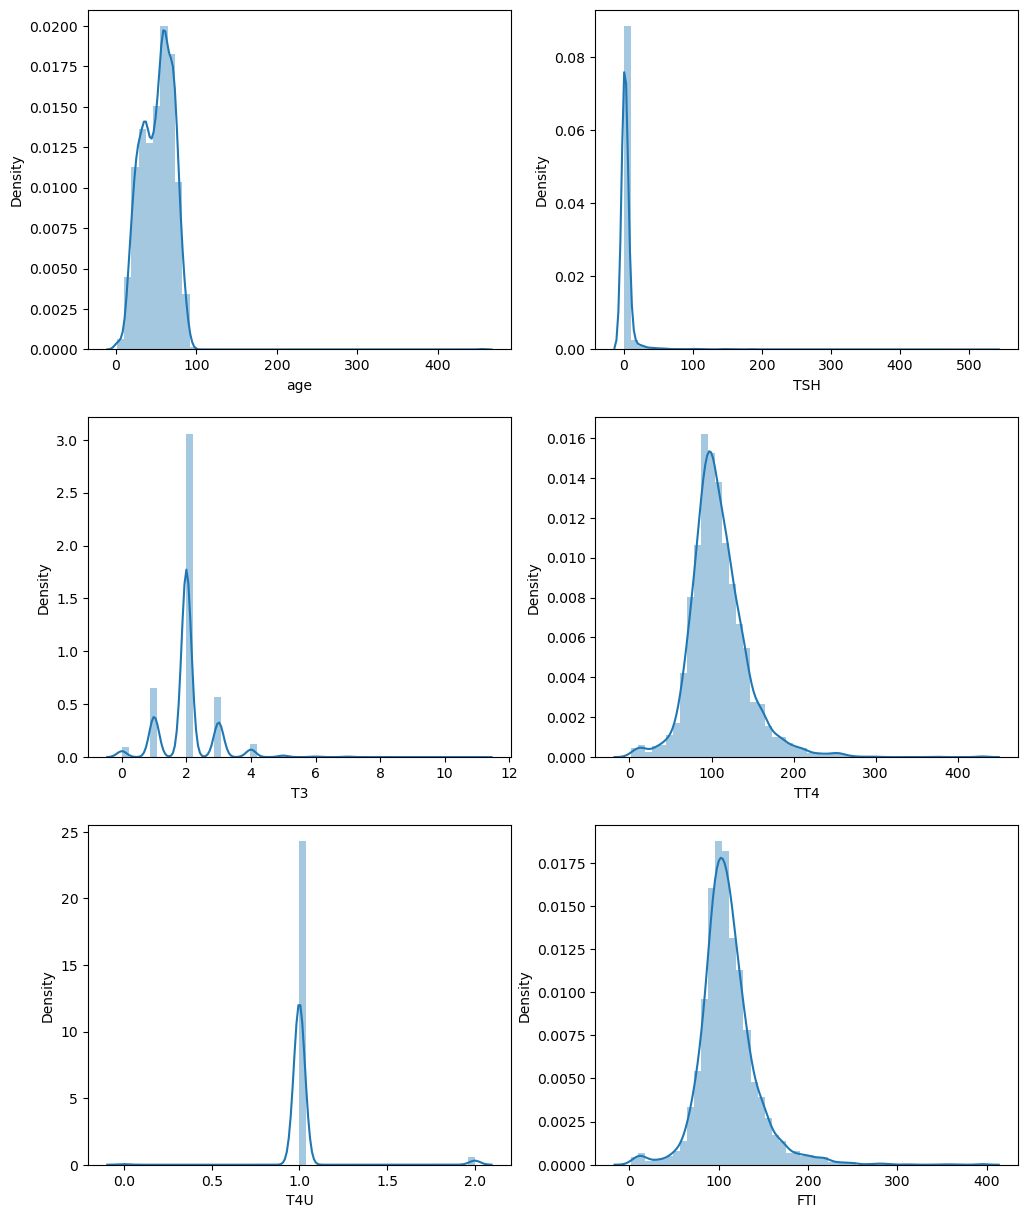

In [28]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plt.figure(figsize=(12,15),facecolor='white')
plotnumber = 1

for column in columns:
    ax = plt.subplot(3,2,plotnumber)
    sns.distplot(new_df[column])
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

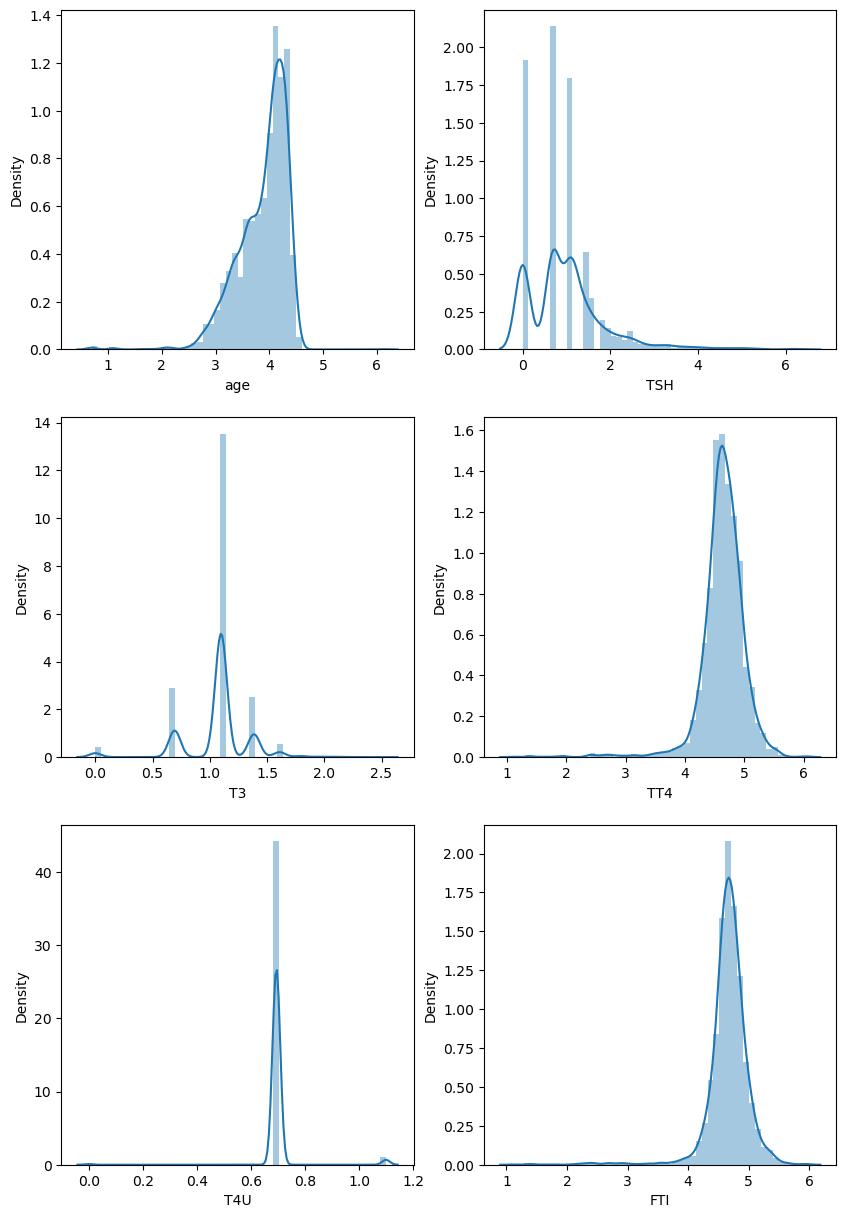

In [29]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plt.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    new_df[column]+=1
    ax = plt.subplot(3,2,plotnumber)
    sns.distplot(np.log(new_df[column]))
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()


In [30]:
new_df = new_df.drop(['TSH'],axis=1)

##### Distribution of Categories

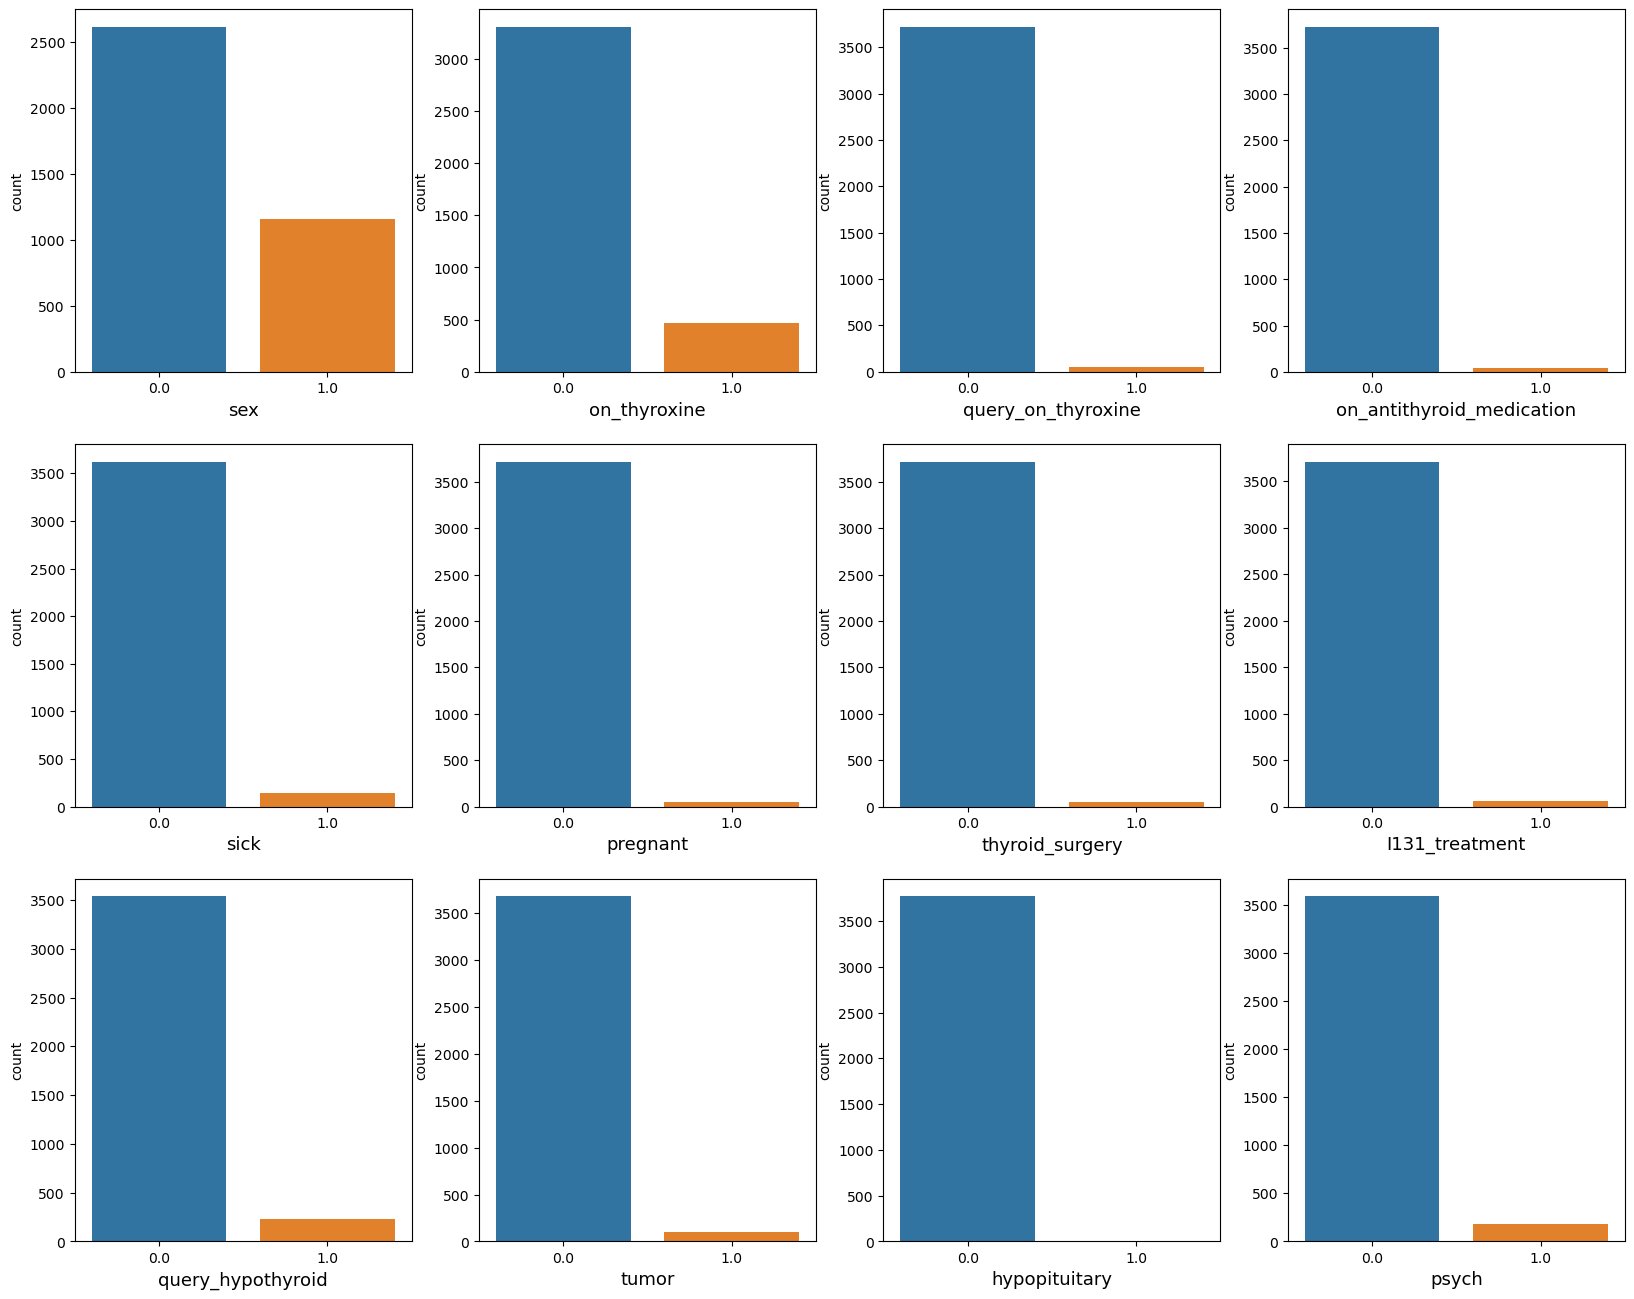

In [31]:
# let's see how data is distributed for every column for every individual id
# the graph plot below is for individual ids. Press 1 in the  input box below the graph to continue viewing graph for each id!!

plt.figure(figsize=(20,16), facecolor='white')
plotnumber = 1
plt_data = new_df[['sex','on_thyroxine','query_on_thyroxine','on_antithyroid_medication','sick','pregnant','thyroid_surgery','I131_treatment','query_hypothyroid','tumor','hypopituitary','psych']]

for column in plt_data:
    ax = plt.subplot(3,4,plotnumber)
    sns.countplot(plt_data,x=column)
    plt.xlabel(column,fontsize=13)
    plotnumber+=1
plt.show()

##### Distribution of Categories in Target Class

In [32]:
new_df['Class'].value_counts()

Class
1.0    3481
0.0     194
2.0      95
3.0       2
Name: count, dtype: int64

<Axes: xlabel='Class', ylabel='count'>

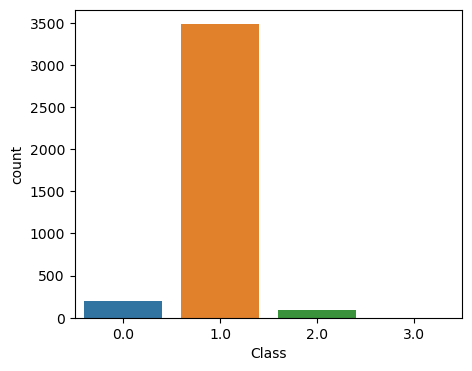

In [33]:
plt.figure(figsize=(5,4))
sns.countplot(new_df, x='Class')

We can clerly see that the dataset is highly imbalanced. 

We will use RandomOverSampler algorithm from python library imbalanced-learn to deal with imbalanced data. 
You can study more about different techniques below.

Note: https://pypi.org/project/imbalanced-learn/

https://github.com/scikit-learn-contrib/imbalanced-learn


Also, ensemble techniques are well versed in handling such imbalanced data. But for the sake of learning we will see how such issues are dealt with.

In [34]:
# cat = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# sm = SMOTENC(categorical_features=cat,sampling_strategy='minority')

In [35]:
# kmsmote=KMeansSMOTE()

In [36]:
x = new_df.drop(['Class'],axis=1)
y = new_df['Class']
rdsmple = RandomOverSampler()
x_balanced,y_balanced  = rdsmple.fit_resample(x,y)

In [37]:
# x_sampled,y_sampled = kmsmote.fit_resample(x,np.asarray(y))

In [38]:
x_balanced.shape

(13924, 24)

In [39]:
x_balanced = pd.DataFrame(data = x_balanced, columns = x.columns)
y_balanced = pd.DataFrame(data = y_balanced, columns = ['Class'])

In [40]:
x_balanced

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,126.0,2.0,110.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,62.0,2.0,71.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,1.0
13920,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,1.0
13921,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,1.0
13922,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,1.0


<Axes: xlabel='Class', ylabel='count'>

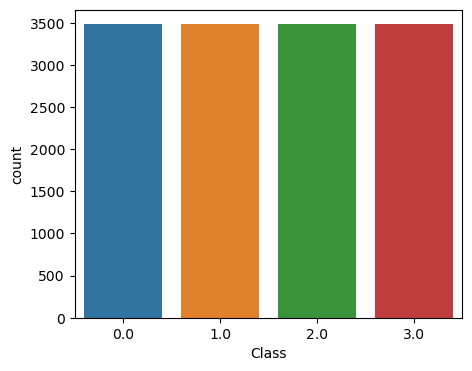

In [41]:
plt.figure(figsize=(5,4))
sns.countplot(y_balanced, x='Class')       

Great! Our dataset looks balanced now. We can go ahead with training our model on this data.

##### Clustering the data

In [42]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [43]:
X,y = x_balanced, y_balanced

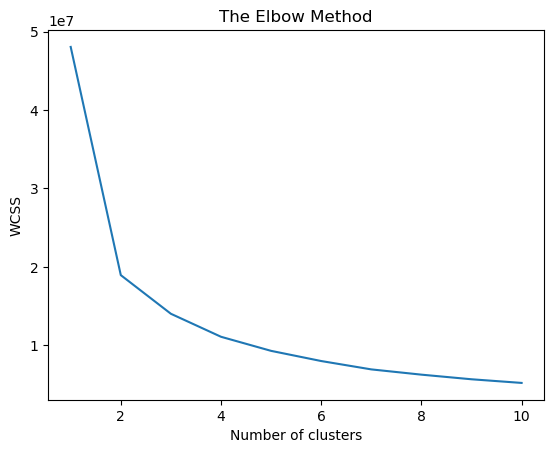

In [44]:
# To find how many clusters to make we will use elbow_plot method 

wcss=[] # Initializing an empty list to save Within Cluster Sum Squares for number of clusters formed
for i in range (1,11):
        kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42) # initializing the KMeans object
        kmeans.fit(X) # fitting the data to the KMeans Algorithm
        wcss.append(kmeans.inertia_)
            
            
plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [45]:
# To find the value of the optimum clusters we will use the KneeLocator 
# Will find the point where the steep decrease in wcss is diminished
kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
number_of_clusters = kn.knee
number_of_clusters

3

In [46]:
# Now let's create clusters using optimum number of clusters

kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
kmeans_clusters = kmeans.fit_predict(X) #  divide data into clusters

X['Cluster'] = kmeans_clusters  # create a new column in dataset for storing the cluster information

In [47]:
list_of_clusters = X['Cluster'].unique()
list_of_clusters

array([2, 0, 1])

##### Finding best model for each individual Cluster formed

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics  import roc_auc_score,accuracy_score,classification_report

In [49]:
def best_tuned_rfc_model(x_train, y_train):
    param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],
                  "max_depth": range(2, 4, 1), "max_features": ['auto', 'log2']}
    grid_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5,  verbose=3)
    grid_rfc.fit(x_train, y_train)
    # Storing the best Parameters
    n_estimators=grid_rfc.best_params_['n_estimators']
    criterion=grid_rfc.best_params_['criterion']
    max_depth=grid_rfc.best_params_['max_depth']
    max_features=grid_rfc.best_params_['max_features']
    
    rfc=RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,max_features=max_features)
    rfc.fit(x_train,y_train)
    
    return rfc

In [50]:
def best_tuned_knn_model(x_train, y_train):
    param_grid_knn = {'algorithm' : ['ball_tree', 'kd_tree', 'brute'],'leaf_size' : [10,17,24,28,30,35],
                      'n_neighbors':[4,5,8,10,11],'p':[1,2]}
    grid_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, verbose=3,cv=5)
    grid_knn.fit(x_train, y_train)
    # Storing the best Parameters
    algorithm=grid_knn.best_params_['algorithm']
    leaf_size=grid_knn.best_params_['leaf_size']
    n_neighbors=grid_knn.best_params_['n_neighbors']
    p=grid_knn.best_params_['p']
    
    knn = KNeighborsClassifier(algorithm=algorithm, leaf_size=leaf_size, n_neighbors=n_neighbors,p=p,n_jobs=-1)    
    knn.fit(x_train,y_train)
    
    return knn

In [51]:
def model_selection(x_train,y_train,x_test,y_test):
    
    # Model Evaluation for rfc
    rfc = best_tuned_rfc_model(x_train,y_train)
    pred_rfc = rfc.predict(x_test)
    pred_rfc_prob = rfc.predict_proba(x_test)
    rfc_accuracy = accuracy_score(y_test, pred_rfc)
    rfc_report = classification_report(y_test, pred_rfc)
    rfc_ROC_AUC = roc_auc_score(y_test, pred_rfc_prob, multi_class='ovr')
    
    ## Model Evalutaion for knn
    knn = best_tuned_knn_model(x_train,y_train)
    pred_knn = knn.predict(x_test)
    pred_knn_prob = knn.predict_proba(x_test)
    knn_accuracy = accuracy_score(y_test, pred_knn)
    knn_report = classification_report(y_test, pred_knn)
    knn_ROC_AUC = roc_auc_score(y_test, pred_knn_prob, multi_class='ovr')
    
    
    evaluation_results = {"RandomForest": {"Model": rfc,
                                           "Accuracy": rfc_accuracy,
#                                            "ClassificationReport": rfc_report,
                                           "ROC_AUC": rfc_ROC_AUC},
                          
                    "k-NearestNeighbors": {"Model": knn,
                                           "Accuracy": knn_accuracy,
#                                            "ClassificationReport": knn_report,
                                           "ROC_AUC": knn_ROC_AUC }
                         }

    return evaluation_results

In [52]:
clustered_df = pd.concat([X,y], axis=1)

In [53]:
# Segregating the data for each cluster using for loop
cluster_results = []
for i in list_of_clusters:
    cluster_data=clustered_df.loc[clustered_df['Cluster']==i] # filter the data for one cluster

    # Prepare the feature and Label columns
    cluster_features=cluster_data.drop(['Class','Cluster'],axis=1)
    cluster_label= cluster_data['Class']

    # splitting the data into training and test set for each cluster one by one
    x_train, x_test, y_train, y_test = train_test_split(cluster_features, cluster_label, test_size=1/3, random_state=355)
    
    #getting the best model for each of the clusters
    evaluation_results = model_selection(x_train,y_train,x_test,y_test)
    
    cluster_results.append({'Cluster_group':i, 'Model_results':evaluation_results})
    

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.687 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.689 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.702 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.689 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=10;, score=0.686 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=50;, score=0.687 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=50;, score=0.689 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=2, max_features=auto, n_estimators=50;, score=0.689 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=2, max_features=aut

[CV 5/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=100;, score=0.686 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=130;, score=0.687 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=130;, score=0.689 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=130;, score=0.689 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=130;, score=0.689 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=130;, score=0.686 total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=2, max_features=auto, n_estimators=10;, score=0.687 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=2, max_features=auto, n_estimators=10;, score=0.689 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=2, max_features=auto, n_estimators=10;, score=0.689 total time=   

[CV 5/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=50;, score=0.686 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100;, score=0.687 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100;, score=0.699 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100;, score=0.696 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100;, score=0.702 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=100;, score=0.686 total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=130;, score=0.687 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=130;, score=0.689 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=3, max_features=log2, n_estimators=130;, score=

[CV 5/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=5, p=2;, score=0.910 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=1;, score=0.864 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=1;, score=0.863 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=1;, score=0.857 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=1;, score=0.866 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=1;, score=0.857 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2;, score=0.867 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2;, score=0.863 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2;, score=0.863 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=8, p=2;, score=0.882 total time=   0.0s


[CV 4/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=4, p=1;, score=0.910 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=4, p=1;, score=0.891 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=4, p=2;, score=0.904 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=4, p=2;, score=0.925 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=4, p=2;, score=0.891 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=4, p=2;, score=0.929 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=4, p=2;, score=0.910 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=1;, score=0.901 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=1;, score=0.904 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=5, p=1;, score=0.894 total time=   0.0s


[CV 3/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=10, p=2;, score=0.842 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=10, p=2;, score=0.854 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=10, p=2;, score=0.817 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=1;, score=0.848 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=1;, score=0.839 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=1;, score=0.842 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=1;, score=0.832 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=1;, score=0.842 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2;, score=0.848 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=11, p=2;, score=0.832 total tim

[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2;, score=0.867 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2;, score=0.866 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2;, score=0.863 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2;, score=0.882 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=8, p=2;, score=0.851 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.839 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.835 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.848 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.832 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.839 total time=   0.0s
[CV 1/5] END al

[CV 2/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.929 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.888 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.919 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.907 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.867 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.860 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.860 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.857 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=1;, score=0.857 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=8, p=2;, score=0.867 total time=   0.0s
[CV 2/5] END algorit

[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.904 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.894 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.907 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=1;, score=0.891 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.904 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.929 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.891 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.929 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=4, p=2;, score=0.907 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=5, p=1;, score=0.904 total time=   0.0s
[CV 2/5] END algorit

[CV 3/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.848 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.832 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=1;, score=0.839 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2;, score=0.851 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2;, score=0.832 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2;, score=0.842 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2;, score=0.857 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=11, p=2;, score=0.820 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=10, n_neighbors=4, p=1;, score=0.895 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=10, n_neighbors=4, p=1;, score=0.904 total time=   0.0s
[CV 3/5] END alg

[CV 5/5] END algorithm=brute, leaf_size=17, n_neighbors=8, p=2;, score=0.845 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=17, n_neighbors=10, p=1;, score=0.830 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=17, n_neighbors=10, p=1;, score=0.829 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=17, n_neighbors=10, p=1;, score=0.832 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=17, n_neighbors=10, p=1;, score=0.832 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=17, n_neighbors=10, p=1;, score=0.829 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=17, n_neighbors=10, p=2;, score=0.851 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=17, n_neighbors=10, p=2;, score=0.829 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=17, n_neighbors=10, p=2;, score=0.842 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=17, n_neighbors=10, p=2;, score=0.857 total time=   0.0s
[CV 5/5] END algorithm=brute, l

[CV 5/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=1;, score=0.888 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=2;, score=0.907 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=2;, score=0.925 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=2;, score=0.888 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=2;, score=0.919 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=28, n_neighbors=5, p=2;, score=0.907 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=28, n_neighbors=8, p=1;, score=0.858 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=28, n_neighbors=8, p=1;, score=0.857 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=28, n_neighbors=8, p=1;, score=0.863 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=28, n_neighbors=8, p=1;, score=0.860 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=

[CV 2/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.904 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.894 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.904 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=1;, score=0.888 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=2;, score=0.907 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=2;, score=0.922 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=2;, score=0.891 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=2;, score=0.929 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=35, n_neighbors=4, p=2;, score=0.907 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=35, n_neighbors=5, p=1;, score=0.895 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=

[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=100;, score=0.597 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=100;, score=0.608 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=100;, score=0.620 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=130;, score=0.600 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=130;, score=0.595 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=130;, score=0.618 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=130;, score=0.619 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=2, max_features=log2, n_estimators=130;, score=0.590 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=10;, score=0.675 total time=   0.0s
[C

[CV 2/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=50;, score=0.622 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=50;, score=0.600 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=50;, score=0.606 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=50;, score=0.582 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=100;, score=0.605 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=100;, score=0.579 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=100;, score=0.595 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=100;, score=0.622 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=2, max_features=log2, n_estimators=100;, score=0.6

[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=8, p=1;, score=0.824 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=8, p=1;, score=0.802 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=8, p=1;, score=0.801 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=8, p=2;, score=0.834 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=8, p=2;, score=0.835 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=8, p=2;, score=0.819 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=8, p=2;, score=0.797 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=8, p=2;, score=0.817 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.805 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=10, p=1;, score=0.803 total time=   0.0

[CV 2/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=4, p=2;, score=0.888 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=4, p=2;, score=0.890 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=4, p=2;, score=0.866 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=4, p=2;, score=0.869 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1;, score=0.885 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1;, score=0.888 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1;, score=0.878 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1;, score=0.850 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=1;, score=0.857 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=5, p=2;, score=0.893 total time=   0.0s


[CV 1/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1;, score=0.813 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1;, score=0.800 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1;, score=0.798 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1;, score=0.786 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=1;, score=0.787 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=2;, score=0.821 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=2;, score=0.816 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=2;, score=0.794 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=2;, score=0.776 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=28, n_neighbors=11, p=2;, score=0.793 total tim

[CV 5/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=1;, score=0.800 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2;, score=0.835 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2;, score=0.835 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2;, score=0.819 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2;, score=0.797 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=8, p=2;, score=0.814 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=10, p=1;, score=0.808 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=10, p=1;, score=0.800 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=10, p=1;, score=0.803 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=10, p=1;, score=0.789 total time=   0

[CV 2/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1;, score=0.888 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1;, score=0.883 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1;, score=0.854 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=1;, score=0.859 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2;, score=0.890 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2;, score=0.891 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2;, score=0.894 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2;, score=0.867 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=5, p=2;, score=0.865 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=8, p=1;, score=0.842 total time=   0.0s
[CV 2/5] END algorit

[CV 5/5] END algorithm=kd_tree, leaf_size=24, n_neighbors=11, p=2;, score=0.795 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=4, p=1;, score=0.885 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=4, p=1;, score=0.890 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=4, p=1;, score=0.880 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=4, p=1;, score=0.853 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=4, p=1;, score=0.862 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=4, p=2;, score=0.893 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=4, p=2;, score=0.890 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=4, p=2;, score=0.894 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=4, p=2;, score=0.867 total time=   0.0s
[CV 5/5] END algori

[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=2;, score=0.818 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=2;, score=0.814 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=2;, score=0.802 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=2;, score=0.784 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=10, p=2;, score=0.798 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1;, score=0.808 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1;, score=0.808 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1;, score=0.802 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1;, score=0.789 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1;, score=0.792 total time=   0.0s
[CV 1/5] E

[CV 5/5] END algorithm=brute, leaf_size=10, n_neighbors=5, p=2;, score=0.865 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=10, n_neighbors=8, p=1;, score=0.832 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=10, n_neighbors=8, p=1;, score=0.821 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=10, n_neighbors=8, p=1;, score=0.822 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=10, n_neighbors=8, p=1;, score=0.816 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=10, n_neighbors=8, p=1;, score=0.804 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=10, n_neighbors=8, p=2;, score=0.834 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=10, n_neighbors=8, p=2;, score=0.837 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=10, n_neighbors=8, p=2;, score=0.818 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=10, n_neighbors=8, p=2;, score=0.800 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=

[CV 1/5] END algorithm=brute, leaf_size=24, n_neighbors=4, p=2;, score=0.890 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=24, n_neighbors=4, p=2;, score=0.885 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=24, n_neighbors=4, p=2;, score=0.891 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=24, n_neighbors=4, p=2;, score=0.866 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=24, n_neighbors=4, p=2;, score=0.869 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=24, n_neighbors=5, p=1;, score=0.875 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=24, n_neighbors=5, p=1;, score=0.874 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=24, n_neighbors=5, p=1;, score=0.875 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=24, n_neighbors=5, p=1;, score=0.854 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=24, n_neighbors=5, p=1;, score=0.854 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=

[CV 4/5] END algorithm=brute, leaf_size=28, n_neighbors=11, p=1;, score=0.784 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=28, n_neighbors=11, p=1;, score=0.798 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=28, n_neighbors=11, p=2;, score=0.821 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=28, n_neighbors=11, p=2;, score=0.814 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=28, n_neighbors=11, p=2;, score=0.794 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=28, n_neighbors=11, p=2;, score=0.774 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=28, n_neighbors=11, p=2;, score=0.793 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=30, n_neighbors=4, p=1;, score=0.874 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=30, n_neighbors=4, p=1;, score=0.872 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=30, n_neighbors=4, p=1;, score=0.874 total time=   0.0s
[CV 4/5] END algorithm=brute, lea

[CV 2/5] END algorithm=brute, leaf_size=35, n_neighbors=10, p=1;, score=0.798 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=35, n_neighbors=10, p=1;, score=0.808 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=35, n_neighbors=10, p=1;, score=0.795 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=35, n_neighbors=10, p=1;, score=0.784 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=35, n_neighbors=10, p=2;, score=0.818 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=35, n_neighbors=10, p=2;, score=0.814 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=35, n_neighbors=10, p=2;, score=0.802 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=35, n_neighbors=10, p=2;, score=0.782 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=35, n_neighbors=10, p=2;, score=0.796 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=35, n_neighbors=11, p=1;, score=0.816 total time=   0.0s
[CV 2/5] END algorithm=brute, 

[CV 3/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=130;, score=0.970 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=130;, score=0.977 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=3, max_features=auto, n_estimators=130;, score=0.976 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=10;, score=0.971 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=10;, score=0.964 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=10;, score=0.970 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=10;, score=0.977 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=10;, score=0.976 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=3, max_features=log2, n_estimators=50;, score=0.971 total time=   0.0s
[CV 2/5

[CV 1/5] END criterion=entropy, max_depth=3, max_features=auto, n_estimators=100;, score=0.971 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=3, max_features=auto, n_estimators=100;, score=0.974 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=3, max_features=auto, n_estimators=100;, score=0.970 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=3, max_features=auto, n_estimators=100;, score=0.977 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=3, max_features=auto, n_estimators=100;, score=0.976 total time=   0.1s
[CV 1/5] END criterion=entropy, max_depth=3, max_features=auto, n_estimators=130;, score=0.971 total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=3, max_features=auto, n_estimators=130;, score=0.974 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=3, max_features=auto, n_estimators=130;, score=0.970 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=3, max_features=auto, n_estimators=130;, score

[CV 5/5] END algorithm=ball_tree, leaf_size=10, n_neighbors=11, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=1;, score=0.995 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=1;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=17, n_neighbors=4, p=2;, score=0.992 total time=   0.0s

[CV 2/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=24, n_neighbors=11, p=1;, score=0.992 total tim

[CV 1/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=5, p=2;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=5, p=2;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=5, p=2;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=5, p=2;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=5, p=2;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=8, p=1;, score=0.992 total time=   0.0s


[CV 5/5] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.995 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=1;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=10, n_neighbors=4, p=2;, score=0.992 total time=   0.0s
[CV 5/5] END algo

[CV 1/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=17, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 1/5] E

[CV 1/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=8, p=2;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=8, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=8, p=2;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=8, p=2;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=28, n_neighbors=8, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorit

[CV 1/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=4, p=2;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=5, p=1;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=5, p=1;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=5, p=1;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=5, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=kd_tree, leaf_size=35, n_neighbors=5, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorit

[CV 2/5] END algorithm=brute, leaf_size=10, n_neighbors=11, p=1;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=10, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=10, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=10, n_neighbors=11, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=10, n_neighbors=11, p=2;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=10, n_neighbors=11, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=10, n_neighbors=11, p=2;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=10, n_neighbors=11, p=2;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=10, n_neighbors=11, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=17, n_neighbors=4, p=1;, score=0.993 total time=   0.0s
[CV 2/5] END algorithm=brute, l

[CV 3/5] END algorithm=brute, leaf_size=24, n_neighbors=8, p=2;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=24, n_neighbors=8, p=2;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=24, n_neighbors=8, p=2;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=24, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=24, n_neighbors=10, p=1;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=24, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=24, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=24, n_neighbors=10, p=1;, score=0.992 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=24, n_neighbors=10, p=2;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=24, n_neighbors=10, p=2;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=brute, lea

[CV 4/5] END algorithm=brute, leaf_size=30, n_neighbors=5, p=1;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=30, n_neighbors=5, p=1;, score=0.993 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=30, n_neighbors=5, p=2;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=30, n_neighbors=5, p=2;, score=0.994 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=30, n_neighbors=5, p=2;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=30, n_neighbors=5, p=2;, score=0.992 total time=   0.0s
[CV 5/5] END algorithm=brute, leaf_size=30, n_neighbors=5, p=2;, score=0.994 total time=   0.0s
[CV 1/5] END algorithm=brute, leaf_size=30, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 2/5] END algorithm=brute, leaf_size=30, n_neighbors=8, p=1;, score=0.993 total time=   0.0s
[CV 3/5] END algorithm=brute, leaf_size=30, n_neighbors=8, p=1;, score=0.992 total time=   0.0s
[CV 4/5] END algorithm=brute, leaf_size=

[CV 5/5] END algorithm=brute, leaf_size=35, n_neighbors=11, p=2;, score=0.992 total time=   0.0s


In [54]:
cluster_results[0]

{'Cluster_group': 2,
 'Model_results': {'RandomForest': {'Model': RandomForestClassifier(max_depth=3, max_features='auto', n_estimators=10),
   'Accuracy': 0.6612903225806451,
   'ROC_AUC': 0.8940128018816736},
  'k-NearestNeighbors': {'Model': KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_jobs=-1,
                        n_neighbors=4),
   'Accuracy': 0.93424317617866,
   'ROC_AUC': 0.9860641242998328}}}

In [55]:
for cluster_group in list_of_clusters:
    print(f'Model Evaluation for Cluster Group {cluster_group} :')
    print('---------------------------------------------------')
    
    # RFC evaluation 
    model, acc,roc_auc=[cluster_results[cluster_group]['Model_results']['RandomForest'][metrics] for metrics in ['Model','Accuracy','ROC_AUC']]
    print(f'Model: RandomForestClassifier')
    print(f' Accuracy_score = {acc}  and  ROC_AUC score = {roc_auc}',end='\n\n')
   
    # KNN evaluation
    model, acc,roc_auc=[cluster_results[cluster_group]['Model_results']['k-NearestNeighbors'][metrics] for metrics in ['Model','Accuracy','ROC_AUC']]
    print(f'Model: KNeighborsClassifier')
    print(f' Accuracy_score = {acc}  and  ROC_AUC score = {roc_auc}', end='\n\n\n')

Model Evaluation for Cluster Group 2 :
---------------------------------------------------
Model: RandomForestClassifier
 Accuracy_score = 0.9731750219876869  and  ROC_AUC score = 0.9901972735343576

Model: KNeighborsClassifier
 Accuracy_score = 0.9956024626209323  and  ROC_AUC score = 0.9409950247112857


Model Evaluation for Cluster Group 0 :
---------------------------------------------------
Model: RandomForestClassifier
 Accuracy_score = 0.6612903225806451  and  ROC_AUC score = 0.8940128018816736

Model: KNeighborsClassifier
 Accuracy_score = 0.93424317617866  and  ROC_AUC score = 0.9860641242998328


Model Evaluation for Cluster Group 1 :
---------------------------------------------------
Model: RandomForestClassifier
 Accuracy_score = 0.6928982725527831  and  ROC_AUC score = 0.8608241724654709

Model: KNeighborsClassifier
 Accuracy_score = 0.9053103007037748  and  ROC_AUC score = 0.9704311562493219


